In [284]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Machine Learning for physics

# Practical Work 1 : Classification via k-Nearest Neighbors

## Introduction

The k-Nearest Neighbors algorithm is one of the simplest method for classification (and regression). The function value or the class belonging are determined locally by the 'vote' of the $k$ nearest neighbors.

## Generating data

We build two sets (`class0` et `class1`) of centroids. These sets are distributed via the standard normal distribution around one central point for each class. Every class contains the same number of points `centroid_per_class`.

Text(0.5, 1.0, 'Centroids')

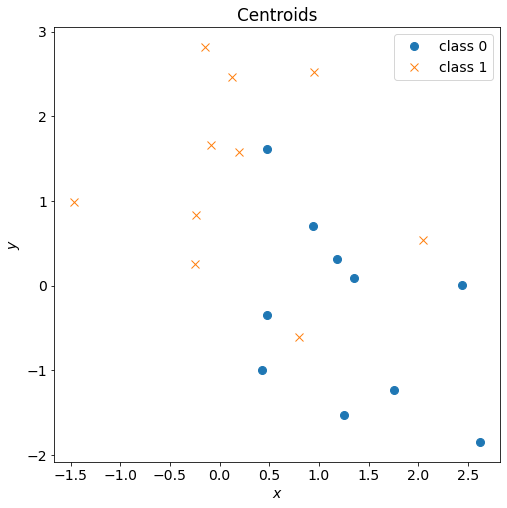

In [285]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

# Plot centroids
plt.plot(class0_centroids[:, 0], class0_centroids[:, 1], "o", markersize=8, label="class 0")
plt.plot(class1_centroids[:, 0], class1_centroids[:, 1], "x", markersize=8, label="class 1")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Centroids")

The number of samples to be generated per class is fixed by `samples_per_class`. Each sample is computed as follows: A centroid is drawn from the corresponding class; the sample position is randomly drawn via a bivariate gaussian centered at the selected centroid.

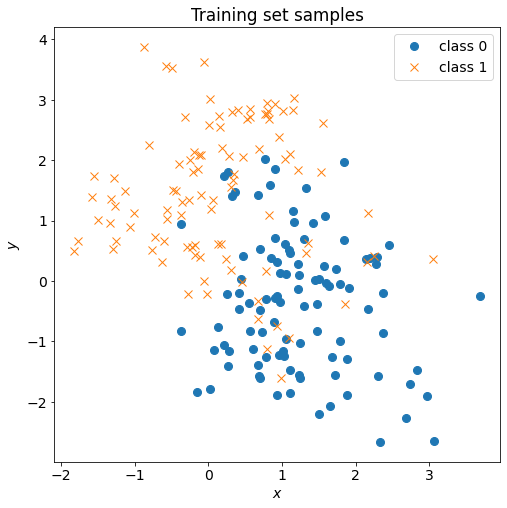

In [286]:
samples_per_class = 100

# Sample actual data sampling from Normal distributions 
# positioned around the centroids
class0_labels = np.random.randint(centroids_per_class, size = samples_per_class)
class1_labels = np.random.randint(centroids_per_class, size = samples_per_class)

class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1./5) * np.random.randn(samples_per_class, 2)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1./5) * np.random.randn(samples_per_class, 2)

# Plot data
plt.plot(class0_samples[:, 0], class0_samples[:, 1], "o", markersize=8, label="class 0")
plt.plot(class1_samples[:, 0], class1_samples[:, 1], "x", markersize=8, label="class 1")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Training set samples")
plt.legend()

**Goal**: Classify new samples in one or the other class.

### Practical data representation

We build the sample array $X$, of shape $(N, P=2)$, and the label array $Y$, of shape $(N, )$.

In [287]:
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

n_samples, n_features = np.shape(X)

### Distance matrix

We try to compute the distances between each sample of two arrays.

In [288]:
def compute_distances(X):
    """
    Return a array of the distances between each point in X.
    
    arg X: a (N, p) array of N samples described by p features;
    
    return: a N x N matrix, where the (i, j) element is the distance 
    between the i^th and the j^th points of X. (Of course the returned matrix 
    is symmetric but it is exploited here.)
    """
    distances = np.empty((len(X), len(X)))
    for (row_counter, point) in enumerate(X):
        diff_squared = (X - point)**2
        distances[row_counter] = np.sqrt(diff_squared[:, 0] + diff_squared[:, 1])
    return distances

Still one loop remains... Solution suggested during lecture: using `np.newaxis`.

In [289]:
a1 = np.array([[1., 1., 0.1],
               [2., 2., 0.2]])
a2 = np.array([[0., 1., -0.1],
               [2., 0., -0.2],
               [1., 5., -0.3],
               [4., 2., -0.4]])

In [290]:
a1_new = a1[:, np.newaxis, :]
print(a1_new)
print(np.shape(a1_new))

[[[1.  1.  0.1]]

 [[2.  2.  0.2]]]
(2, 1, 3)


In [291]:
b = a1_new - a2
print(b)

[[[ 1.   0.   0.2]
  [-1.   1.   0.3]
  [ 0.  -4.   0.4]
  [-3.  -1.   0.5]]

 [[ 2.   1.   0.3]
  [ 0.   2.   0.4]
  [ 1.  -3.   0.5]
  [-2.   0.   0.6]]]


In [292]:
b_sq = np.sum(b**2, axis=2)
print(b_sq)

[[ 1.04  2.09 16.16 10.25]
 [ 5.09  4.16 10.25  4.36]]


In [293]:
d = np.sqrt(b_sq)
print(d)

[[1.0198039  1.44568323 4.01995025 3.20156212]
 [2.25610283 2.03960781 3.20156212 2.0880613 ]]


These steps seem to give the right result. We define the function 

In [294]:
def compute_distances_no_loop(a1, a2):
    """
    Return an array of the distances between each point in a1, a2. Uses np.newaxis to avoid loop.
    
    arg a1: a (N1, p) array containing N1 samples of p features;
    arg a2: a (N2, p) ... N2 samples ... p features ; 
    
    return: a (N1, N2) array containing the distances between each sample of a1 and a2.
    """
    a1_newaxis = a1[:, np.newaxis, :]
    distance_sq = np.sum((a1_newaxis - a2)**2, axis=2)
    return np.sqrt(distance_sq)

Let us check that this function returns the expected result for `a1`, `a2`:

In [295]:
assert compute_distances_no_loop(a1, a2).all() == d.all()

In [296]:
del a1, a2, a1_new, b, b_sq, d

All good! Now let's compare this home-made function with optimised imported functions.

In [297]:
# Time comparison between the home-made distance function and
# imported functions

# Home-made function
distances = compute_distances_no_loop(X, X)
%timeit compute_distances_no_loop(X, X)

# With 'scipy.spatial.distance_matrix'
from scipy.spatial import distance_matrix
distances = distance_matrix(X, X)
%timeit distance_matrix(X, X)

# With 'spipy.spatial.distance.cdist'
from scipy.spatial.distance import cdist
distances_test = cdist(X, X)
%timeit cdist(X, X)

3.52 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.95 ms ± 67.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.04 ms ± 4.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Result: `cdist` is the fastest, it will thus be used thereafter.

## Identifying the $k$-nearest neighbors

In this section we will identify the $k$ nearest neighbors of a given sample.

In [298]:
#?np.argpartition

In [299]:
a = np.array([50, 10, 40, 20, 30, 0, -10])
np.argpartition(a, 2)

array([6, 5, 1, 3, 4, 2, 0])

`np.argpartition(array, rank)` returns an array of indexes. Its shape is the same as the array passed as argument. The rank-th index in the output array is the index of the element in the input array that would be in the rank-th position in a fully-sorted array. The other indexes are placed on the correct side of the rank-th one, but in no specific order.

Let us fiddle with one of the previous toy arrays.

In [300]:
a2 = np.array([[0., 1., -0.1],
               [2., 0., -0.2],
               [1., 5., -0.3],
               [4., 2., -0.4]])
y2 = np.array([0, 0, 1, 1])

In [301]:
d2 = cdist(a2, a2)
print(d2)

[[0.         2.23830293 4.12795349 4.13400532]
 [2.23830293 0.         5.1        2.83548938]
 [4.12795349 5.1        0.         4.24381903]
 [4.13400532 2.83548938 4.24381903 0.        ]]


In [302]:
part0 = np.argpartition(d2, 0)
print(part0)

[[0 1 2 3]
 [1 0 2 3]
 [2 1 0 3]
 [3 1 2 0]]


This gives us, as expected, that the zeroth closest neighbor to a sample is itself. Note that this happens because we are working with one set (training set) only. Working with two (training and test sets), `np.argpartition(d, 0)` would return the index of the *first* neighbor.

In [303]:
part2 = np.argpartition(d2, 2)
print(part2)

[[0 1 2 3]
 [1 0 3 2]
 [2 0 3 1]
 [3 1 0 2]]


In [304]:
labels2 = y2[part2[:, :(2+1)]] #inf is inclusive, sup is exclusive
print(labels2)

[[0 0 1]
 [0 0 1]
 [1 0 1]
 [1 0 0]]


This extracts the corresponding labels from `y2`. Now we need to predict the labels of `a2`'s samples.

In [305]:
predict2 = np.round(np.sum(labels2, axis=1)/(2+1))
print(predict2)

[0. 0. 1. 0.]


The rounding hides the confidence level of the prediction.

Also in the case where `np.sum(labels2, axis=1)/(2+1)` is equal to 0.5, `np.round` will systematically round to the nearest even value (see doc https://numpy.org/doc/stable/reference/generated/numpy.around.html#numpy.around), namely 0. To counter this, we may add a small random noise. 

In [306]:
def noise(width):
    """ Return a random float uniformly distributed over the intervalle [-width/2; +width/2] """
    return width*(np.random.random_sample()-0.5)

Let us write a function that will predict the labels:

In [307]:
def knn_train(X, y, k):
    """
    Return an array of estimated labels via the KNN method.
    
    arg X: both the evaluated data array and the known data neighborhood; 
        contains N samples of p features, so its shape is (N, p)
    arg y: label array associated to the data matrix X, seen as the known 
            neighborhood; shape (N, )
    arg k: the number of nearest neighbors to be looked at
        Warning: here we deal with the same samples for prediction and evaluation. 
        k=0 returns the sample's label with certainty.
        (k+1) appears below so that the k^th column of part is extracted; this also make sure that k=0 works.
    
    return: an array of shape (N, )
    """
    d = cdist(X, X)
    part = np.argpartition(d, k)
    labels = y[part[:, :(k+1)]]
    predict = np.round(np.sum(labels, axis=1)/(k+1) + noise(0.001))
    return predict

We apply this function to the training set.

In [308]:
neighbors = 10
est_labels = knn_train(X, y, neighbors)
print(est_labels)

# Let us compute the training error
train_error = np.mean(y != est_labels)
print(train_error)

[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
0.135


### Plotting the classification results

Text(0.5, 1.0, 'Succes & Failure in classifying the training set')

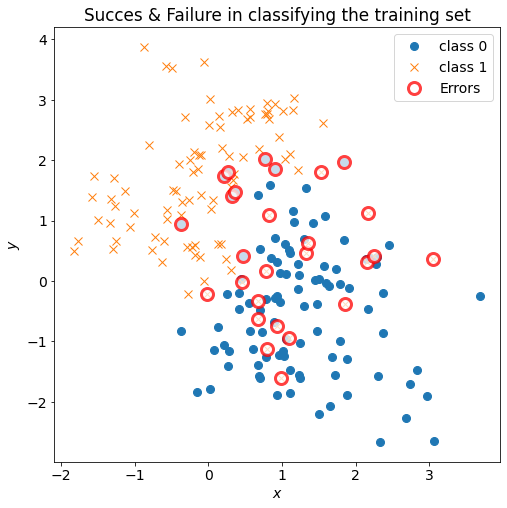

In [309]:
# Plot data
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", ms=8, label="class 0")
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", ms=8, label="class 1")

# Draw a red circle around misclassified samples
errors = (y != est_labels)
plt.plot(X[errors, 0], X[errors, 1], "o", color="red", mew=3, mfc="white", ms=12, alpha=0.75, label="Errors")

# mew = markeredgewidth
# mfc = markerfacecolor
# ms = markersize

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title("Succes & Failure in classifying the training set")

With no suprise, classification usually fails when a sample is isolated in the middle of the other class's samples.

## Testing the model

We generate new samples to build a test set. 

In [310]:
# Sample test data from the model
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), 
                    np.ones(testsamples_per_class)))

# Compute distance matrix between X and X_test
distances_test = cdist(X, X_test)
print(np.shape(distances_test))

(200, 20000)


Text(0.5, 1.0, 'Test set samples')

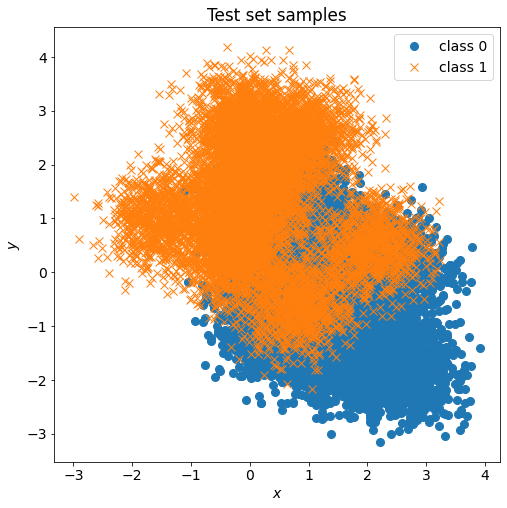

In [311]:
# Plot test data
plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], "o", ms=8, label="class 0")
plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], "x", ms=8, label="class 1")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Test set samples")

### Re-writing the KNN classifier 

In [312]:
def knn_test(X_train, y_train, X_test, y_test, k):
    """
    Return an array of estimated labels via the KNN method.
    
    arg X_train: the known data neighborhood; shape (N_train, p)
    arg y_train: label array associated to the known data matrix X; shape (N_train,)
    arg X_test: the tested data; shape (N_test, p)
    arg y_test: (useless) the label array associated with the tested data X_test, shape (N_test, )
    arg k: the number of nearest neighbors (in the training set) to be looked at.
        0 <= k < N_train
    
    return: an array of dim (N_test, )
    """
    d = cdist(X_test, X_train)
    part = np.argpartition(d, k)
    labels = y_train[part[:, :(k+1)]]
    predict = np.round(np.sum(labels, axis=1)/(k+1) + noise(0.1))
    return predict

In [313]:
# Applying the method to the test set
neighbors = 10
est_testlabels = knn_test(X, y, X_test, y_test, neighbors)
print(est_testlabels)

# Let us compute the test error, now
print(np.mean(y_test != est_testlabels))

[0. 0. 0. ... 1. 1. 1.]
0.1827


###  Studying the training and test failure rates w.r.t. the number of neighbors

k = 1; train error = 0.095, test error = 0.20665
k = 2; train error = 0.105, test error = 0.19395
k = 3; train error = 0.14, test error = 0.193
k = 4; train error = 0.125, test error = 0.18195
k = 5; train error = 0.13, test error = 0.185
k = 6; train error = 0.13, test error = 0.18605
k = 7; train error = 0.13, test error = 0.1852
k = 8; train error = 0.13, test error = 0.1822
k = 9; train error = 0.135, test error = 0.18315
k = 10; train error = 0.135, test error = 0.1827
k = 11; train error = 0.135, test error = 0.1853
k = 12; train error = 0.13, test error = 0.18255
k = 13; train error = 0.125, test error = 0.1839
k = 14; train error = 0.12, test error = 0.18265
k = 15; train error = 0.135, test error = 0.1821
k = 16; train error = 0.13, test error = 0.18045
k = 17; train error = 0.125, test error = 0.18145
k = 18; train error = 0.125, test error = 0.1797
k = 19; train error = 0.12, test error = 0.1807


Text(0.5, 1.0, 'Error rate')

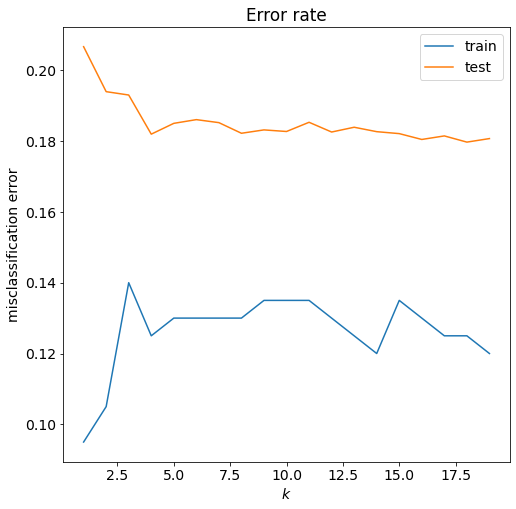

In [314]:
# Convenience functions that compute the training and test errors, given training and test samples
def compute_train_error(X, y, k=1):
    y_hat = knn_train(X, y, k)
    return np.mean(y != y_hat)
    
def compute_test_error(X_train, y_train, X_test, y_test, k=1):
    y_hat = knn_test(X_train, y_train, X_test, y_test, k)
    return np.mean(y_test != y_hat)

# Run functions for k belonging to a range of values
ks = np.arange(1, 20)
train_error = []
test_error = []
for (i, k) in enumerate(ks):
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" \
          % (k, train_error[-1], test_error[-1]))

# Plot results
plt.plot(ks, train_error, label = "train")
plt.plot(ks, test_error, label = "test")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("misclassification error")
plt.title("Error rate")

### Same thing with respect to the number of degrees of freedom

In [315]:
# Re-run the experiment above for a different range of values
ks = np.r_[np.arange(1, 10), np.arange(10, 150, 30)]
train_error = []
test_error = []
for k in ks:
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

k = 1; train error = 0.095, test error = 0.20665
k = 2; train error = 0.105, test error = 0.19395
k = 3; train error = 0.1, test error = 0.19355
k = 4; train error = 0.125, test error = 0.18195
k = 5; train error = 0.13, test error = 0.185
k = 6; train error = 0.13, test error = 0.18605
k = 7; train error = 0.13, test error = 0.1852
k = 8; train error = 0.13, test error = 0.1822
k = 9; train error = 0.135, test error = 0.18275
k = 10; train error = 0.135, test error = 0.1827
k = 40; train error = 0.15, test error = 0.17965
k = 70; train error = 0.155, test error = 0.1885
k = 100; train error = 0.155, test error = 0.19685
k = 130; train error = 0.18, test error = 0.2213


Text(0.5, 1.0, 'Error rate w.r.t. the number of degrees of freedom')

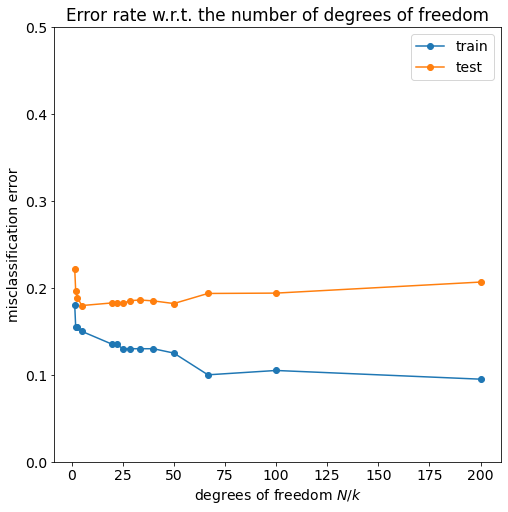

In [316]:
# Plot error as a function of the degrees of freedom
plt.plot(len(y) / np.array(ks), train_error, "-o", label = "train")
plt.plot(len(y) / np.array(ks), test_error, "-o", label = "test")
plt.legend()
plt.xlabel(r"degrees of freedom $N / k$")
plt.ylabel("misclassification error")
plt.ylim((0.0, 0.5))
plt.title("Error rate w.r.t. the number of degrees of freedom")

High number of degrees of freedom (few neighbors) is associated with realy good results on the training set, but not so good results on the test set (the classifyer overfits the training data). The best value for $k$ is close to the one that minimises the test error rate. (This optimum value depends on the specific testset, and may slightly vary if it was determined with another set; hence the usefullness of cross-validation.).

## A Python library for Machine Learning: scikit-learn

In [317]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(10)
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=10)

`.fit` simply trains the classifier with $X$, $y$. Does not find an optimum $k$, nor uses cross-validation. Once the classifier has been trained via `.fit`, it can be used for predictions. Below is computed the train and test error of the classifier (initialized with the hyperparameter $k=10$).

In [318]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
#train_error = 1. - clf.score(X, y)
#test_error = 1. - clf.score(X_test, y_test)

print("train/test error (for k = 10): %g/%g" % (train_error, test_error))

train/test error (for k = 10): 0.13/0.18275


This method performs similarly to our home-made knn function for $k=10$.

### Map of the classification

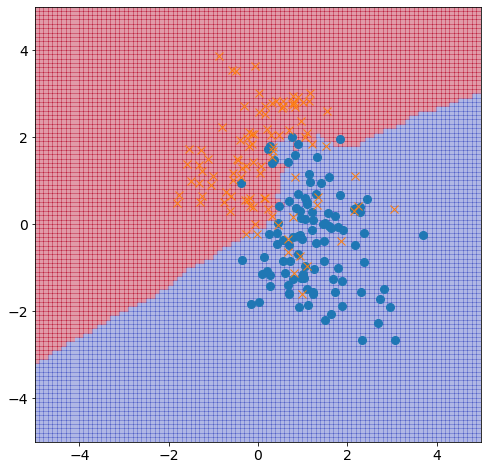

In [331]:
# Create a grid
xx, yy = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Do some plotting
zz = zz.reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap = "coolwarm", alpha = 0.4)
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

Same thing with `predict_proba`:

(101, 101)


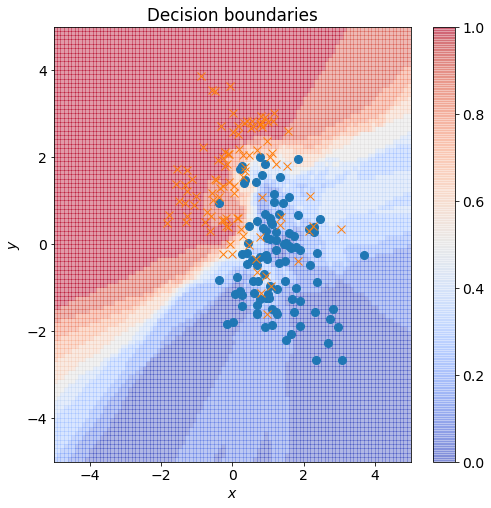

In [330]:
zz_proba = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
zz_proba = zz_proba[:, 1].reshape(xx.shape)
print(np.shape(zz_proba))

plt.pcolormesh(xx, yy, zz_proba, cmap = "coolwarm", alpha = 0.4)
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Decision boundaries")
plt.colorbar()

### Determining the best value of $k$ by cross-validation

In [274]:
from sklearn.model_selection import GridSearchCV

# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 20)}]
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X, y)

# Print results
print(clf.best_params_)

{'n_neighbors': 14}


Let's see how it performs on our datasets

In [174]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for optimal k): %g/%g" % (train_error, test_error))

train/test error (for optimal k): 0.15/0.254


## Classification on real datasets: MNIST

MNIST contains pictures of hand-written numbers.

In [180]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

print(X.shape)
print(y.shape)

n_samples, n_features = np.shape(X)

(70000, 784)
(70000,)


What does this set look like ?

Text(0.5, 1.0, 'A sample from the MNIST set')

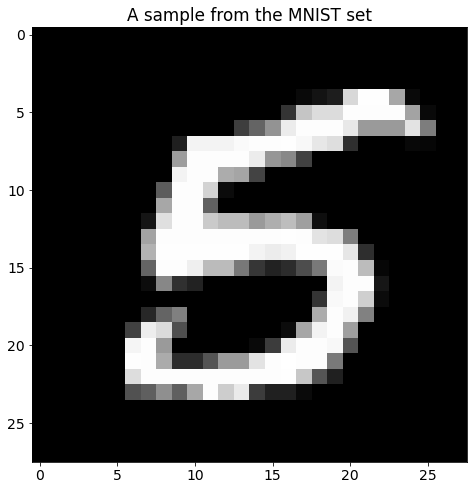

In [182]:
# Plot a sample
plt.imshow(X[20000, :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
plt.title("A sample from the MNIST set")

Let's first devide our data set into a training set and a test set:

In [183]:
# Partition set into train/test
samples = np.random.randint(60000, size = 1000) #choose 1000 indexes amongst the first 6000 samples
X_train, y_train = X[samples, :], y[samples]
X_test, y_test = X[60000:, :], y[60000:] # 10000 test samples!

Then we can instantiate a KNN Classifier from the `sklearn` module.

In [184]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

train_error = 1. - clf.score(X_train, y_train)
test_error = 1. - clf.score(X_test, y_test)
print("train/test error: %g/%g" % (train_error, test_error))

train/test error: 0.095/0.1227


Classification is slow but has the best results so far. Let's look at the falsely classified samples.

(array([ 10,  24,  26,  31,  37,  63,  64,  66,  77, 122, 131, 136, 142,
       155, 202, 205, 214, 215, 218, 222, 232, 261, 270, 276, 277, 280,
       283, 292, 293, 304, 324, 331, 354, 375, 377, 383, 394, 404, 407,
       432, 451, 462, 468, 474, 484, 499, 505, 514, 536, 546, 549, 568,
       586, 596, 597, 605, 607, 615, 637, 639, 643, 645, 647, 657, 658,
       665, 714, 715, 727, 732, 735, 738, 742, 749, 755, 760, 769, 800,
       808, 811, 817, 842, 853, 893, 912, 927, 941, 943, 944, 951, 970,
       975, 976, 980, 992]),)


Text(0.5, 1.0, 'predicted label: 7')

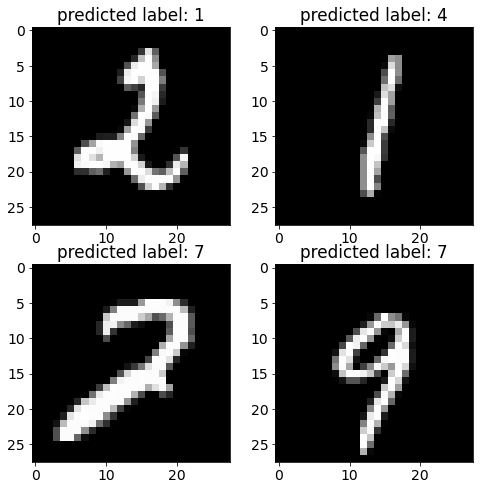

In [185]:
errors = np.where(y_train != clf.predict(X_train))
print(errors)

from random import sample
nums=sample(list(errors[0]),4)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X[nums[0], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 0].set_title("predicted label: %d" % (clf.predict(X_train[nums[0], :].reshape(1, -1))))
axs[0, 1].imshow(X[nums[1], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 1].set_title("predicted label: %d" % (clf.predict(X_train[nums[1], :].reshape(1, -1))))
axs[1, 0].imshow(X[nums[2], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 0].set_title("predicted label: %d" % (clf.predict(X_train[nums[2], :].reshape(1, -1))))
axs[1, 1].imshow(X[nums[3], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 1].set_title("predicted label: %d" % (clf.predict(X_train[nums[3], :].reshape(1, -1))))

In a space of dimension $n$, $\frac{S_{n-1}}{V_n} = \frac{n}{R}$. It means that at fixed radius, the surface dominates the volume when space dimensionnality increases. In other words, in high dimension all samples lie basically at the same distance from each other, so it is difficult to find the *nearest* neighbors. Thus KNN Classifier should be used preferentially after some dimensionn reduction procedure.

## Dataset 'diabetes'

https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

In [187]:
import pandas as pd
#Load the dataset
df = pd.read_csv('TP1/diabetes.csv')
#Print the first 5 rows of the dataframe.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [188]:
#Let's create numpy arrays for features and target
X = df.drop('Outcome',axis=1).values
y = df['Outcome'].values
print(X.shape,y.shape)

(768, 8) (768,)


We divide the data set into a training set, a validation set and a test set, using `scikit-learn`'s method `train_test_split`.

In [220]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=16, stratify=y)

In [240]:
from sklearn.model_selection import GridSearchCV
# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 50)}]
gs = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
gs.fit(X_train, y_train)
print(gs.best_params_)

{'n_neighbors': 8}
[0.66521739 0.68478261 0.70869565 0.71956522 0.72608696 0.72391304
 0.74130435 0.74782609 0.74130435 0.74782609 0.7326087  0.73043478
 0.72608696 0.72826087 0.72608696 0.73478261 0.72391304 0.72391304
 0.71521739 0.72608696 0.71956522 0.72391304 0.72608696 0.72608696
 0.73043478 0.71956522 0.72826087 0.72608696 0.72391304 0.73043478
 0.73695652 0.7326087  0.7326087  0.73478261 0.73043478 0.73695652
 0.7326087  0.73043478 0.73043478 0.73043478 0.73478261 0.72826087
 0.7326087  0.72826087 0.73478261 0.72826087 0.72608696 0.71956522
 0.7173913 ]


Text(0.5, 1.0, 'KNN Classifier error rate w.r.t. the number of neighbors')

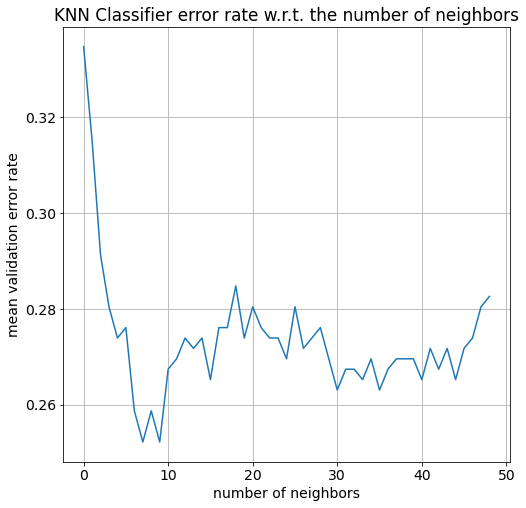

In [259]:
# Print results
plt.plot(1-gs.cv_results_["mean_test_score"])
plt.xlabel("number of neighbors")
plt.ylabel("mean validation error rate")
plt.grid()
plt.title("KNN Classifier error rate w.r.t. the number of neighbors")

Let's see how this optimize classifier performs on the test set:

In [257]:
print("Test error: {:0.3f}".format(1-clf.score(X_test, y_test))

Test error: 0.279


This error rate is of the expected order of magnitude. But it is not really good -- one prediction over 4 is wrong.

## Conclusion

What we have learned :
- write our own KNN Classifier;
- modules from the sklearn librairy, in particular:
    - KNeighborsClassifier(n_neighbors) for prediction, scoring;
    - train_test_split to divide the dataset into a training set and a test set;
    - GridSearchCV(classifier, parameters) to find the best set of parameters for a specified classifier over some dataset;
- influence of the data dimensionality;


What else can be done : 
- add a weight to each neighbor (typically $1/d$ where $d$ is the distance between the sample and the neighbor)
- reduce dimensionnality of the MNIST and diabetes dataset